In [47]:

import numpy as np
import matplotlib.pyplot as plt
import random as random
import math as math
from WeinerGeneratorNumba import getWeiner, getWeinerSubset
#from WeinerGeneratorPandas import getWeinerPandas
from tqdm.notebook import trange, tqdm
from numba import njit
from scipy.optimize import curve_fit

b = -0.05

t0 = 0
tend = 1
steps = 100000
dt = (tend-t0)/steps
h = 1.0
threshold = h/2
Kbar = 1.0

def K(z):
    if z <= threshold:
        K = z*(h-2*z)*Kbar
    else:
        K = (h-z)*(-h+2*z)*Kbar
    return K
    
def dKdz(z):
    if z <= threshold:
        dKdz = h-4*z
    else:
        dKdz = 3*h-4*z
    return dKdz

def dgdz(z):
    #print(z)
    if z < threshold and z > 0:
        dgdz = math.sqrt(2) * (h - 4 * z) / (2 * math.sqrt(z * (h - 2 * z)))
    elif z > threshold and z < h:
        dgdz = math.sqrt(2) * (3 * h - 4 * z) / (2 * math.sqrt(-h**2 + 3 * h * z - 2 * z**2))
    else:
        dgdz = 0
    return dgdz

class Particle():
    def __init__(self, z):
        self.z = z

    
    def simulate(self, ts, dws, dt):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs =self.simulateNumba(self.z, ts, dws, dt)

        return self.zs

    def simulatePython(self, ts, dws, dt):
        """
        Slow pure Python simulation
        """
        self.dt = dt
        self.ts = ts
        self.zs = []
        for index, t in enumerate(ts):
            #Story history
            self.zs.append(self.z)

            #Advance
            z0 = self.z
            z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return self.zs

    def correctBounds(self):
        if abs(self.z) > 2*h:
            print("Severe out of bounds")
            exit()
        if self.z < 0:
            self.z = - self.z
        if self.z > h:
            self.z = 2*h - self.z
        return

    @staticmethod
    @njit
    def simulateNumba(z, ts, dws, dt):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            """
            if z0 <= threshold:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            #calc dKdz(z0)
            if z0 <= threshold:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0
            """

            K = 1 #z0
            dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz*dt + math.sqrt(2*K)*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            z = z1 
        
            #if abs(z) > 2*h:
                #print("WARNING SEVERE OUT OF BOUNDS")
            #if z < 0:
                #z = -z
            #if z > h:
                #z = 2*h - z
        return zs



    def simulate_Milstein(self,ts,dws,dt):
        zs = []
        for index, t in enumerate(ts):
            z0 = self.z
            # z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*random.gauss(0,1)*math.sqrt(dt)#*randomFactor # Euler
            z1 = z0 + dKdz(z0) * dt + math.sqrt(2 * K(z0)) * random.gauss(0,1) * math.sqrt(dt) + 0.5 * math.sqrt(2 * K(z0)) * dgdz(z0) * (random.gauss(0,1)**2 * dt - dt)
            # print(z0, z1)
            if z1 < 0:
                z1 = -z1
            if z1 > h:
                # z1 = 2*h-z1
                z1 = 0.99 # If using Milstein the above won't assure the particles stay within range
            self.z = z1 
        return z1
        


# Generating tracks

## Numba speedup (40x performance improvement)

Wall time: 31 ms
Wall time: 7.02 s


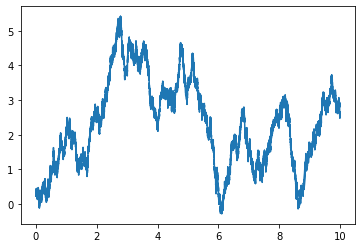

In [48]:
def plotRealization():
    %time ts, ws, dws, dt = getWeiner(1000000,10, 0)
    particle = Particle(0)
    %time zs = particle.simulatePython(ts, dws, dt)

    plt.plot(ts,zs)

plotRealization()

Wall time: 20 ms
Wall time: 1.37 s


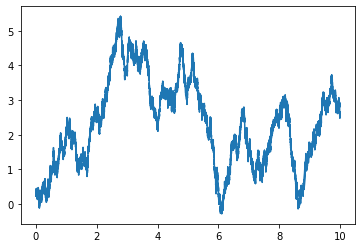

In [49]:
def plotRealization():
    %time ts, ws, dws, dt = getWeiner(1000000,10, 0)
    particle = Particle(0)
    %time zs = particle.simulate(ts, dws, dt)

    plt.plot(ts,zs)

plotRealization()

## Tracks used in this analysis:

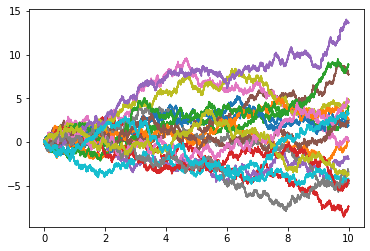

In [50]:
def plotRealization(realization):
    ts, ws, dws, dt = getWeiner(1000000,10, realization)
    particle = Particle(0)
    zs = particle.simulate(ts, dws, dt)

    plt.plot(ts,zs, label = i)

for i in range(20):
    plotRealization(i)

# Interpolation between resolutions

  0%|          | 0/108 [00:00<?, ?it/s]

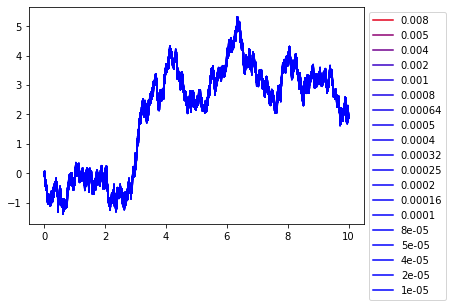

In [51]:
def plotRealizationConvergence(nth):
    ts, ws, dws, dt = getWeinerSubset(nth,1000000,10,0)
    particle = Particle(0)
    zs = particle.simulate(ts, dws, dt)

    plt.plot(ts,zs, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))

iterlist = np.concatenate((np.arange(1,100), np.arange(1,10)*100))
iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution last
maxnth = iterlist[0]

for i in tqdm(iterlist):
    if 1000000%i == 0:
        plotRealizationConvergence(i)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

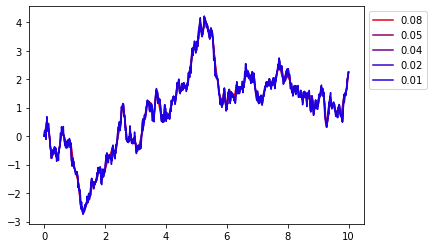

  0%|          | 0/5 [00:00<?, ?it/s]

0.08
0.05
0.04
0.02
0.01


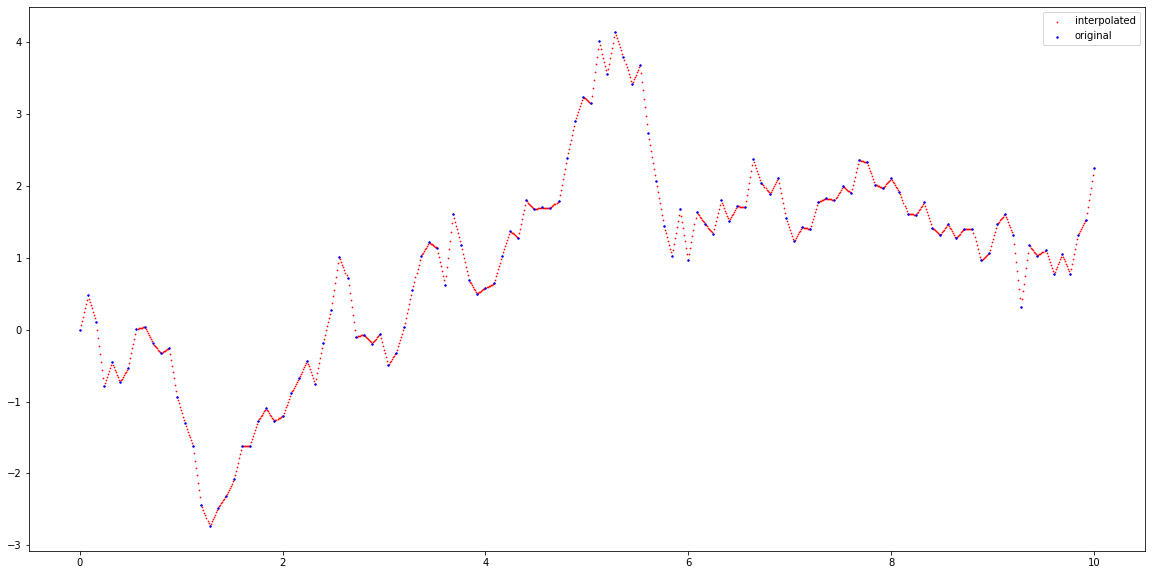

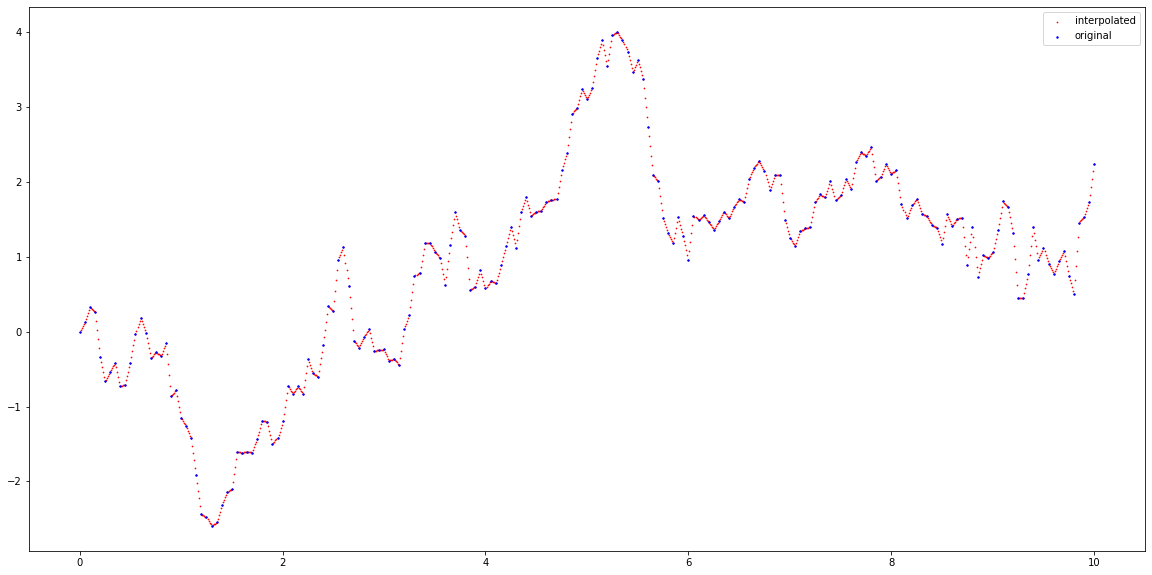

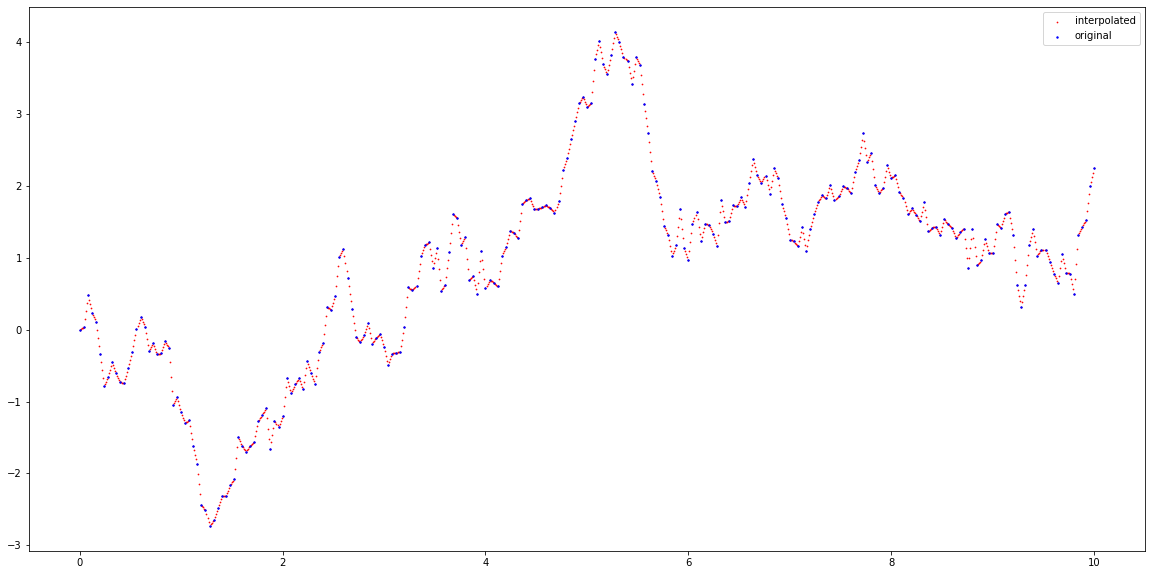

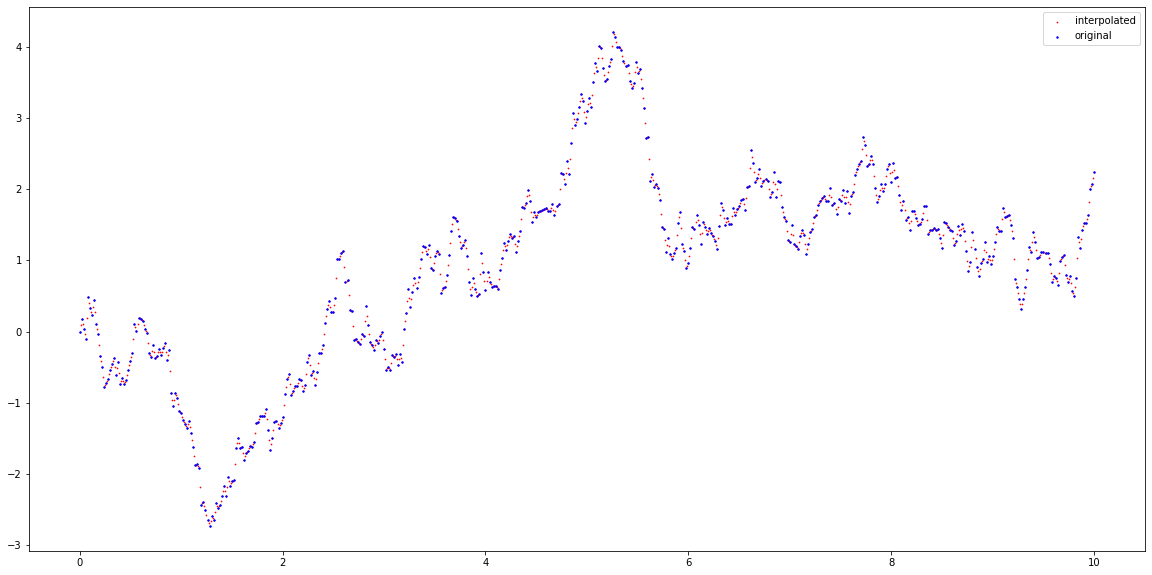

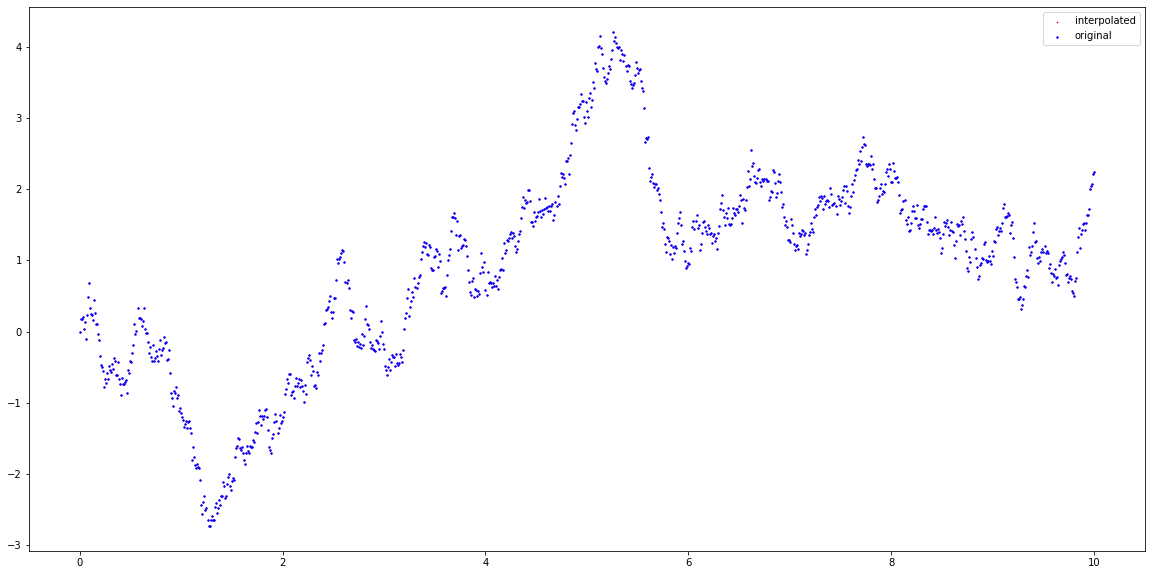

In [52]:
iterlist = np.arange(1,10)
iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
maxnth = iterlist[0]

particles = []
baseSteps = 1000
for i in tqdm(iterlist):
    if baseSteps%i == 0:
        ts, ws, dws, dt = getWeinerSubset(i,baseSteps,10,0)
        particle = Particle(0)
        zs = particle.simulate(ts, dws, dt)
        particles.append(particle)

        plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

zeroParticle = particles[-1]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
for particle in tqdm(particles):
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    plt.figure(figsize=(20,10))
    plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
    plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
    plt.legend()
    print(particle.dt)

Simulate particle with same noise at different dt

  0%|          | 0/9999 [00:00<?, ?it/s]

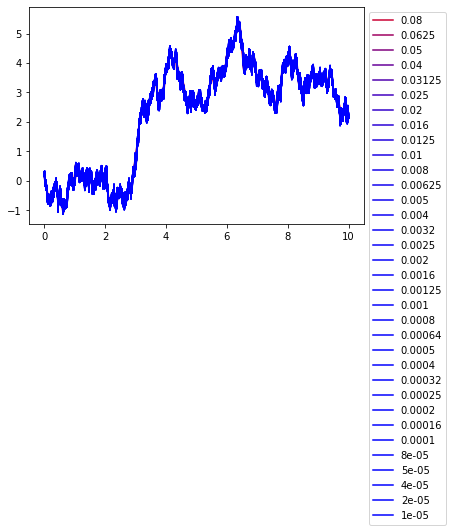

In [53]:
iterlist = np.arange(1,10000)
iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
maxnth = iterlist[0]

particles = []
resolutions = []
baseSteps = 1000000
for i in tqdm(iterlist):
    if baseSteps%i == 0:
        ts, ws, dws, dt = getWeinerSubset(i,baseSteps,10,0)
        particle = Particle(0.25)
        zs = particle.simulate(ts, dws, dt)
        particles.append(particle)

        plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))
        resolutions.append(dt)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Error calculations

[ 0 33 16 11]


C:\Users\serva\AppData\Local\Temp/ipykernel_24744/1718315646.py:10: RuntimeWarning: divide by zero encountered in floor_divide
  particleIndecesToPlot = len(coarserParticles)//np.arange(4)


0it [00:00, ?it/s]

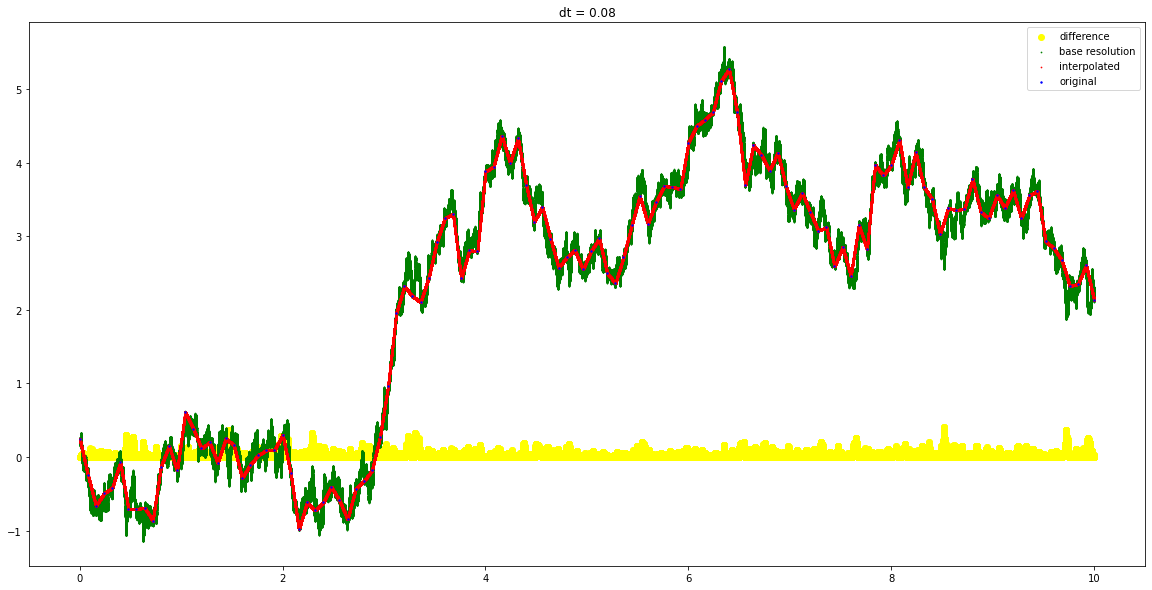

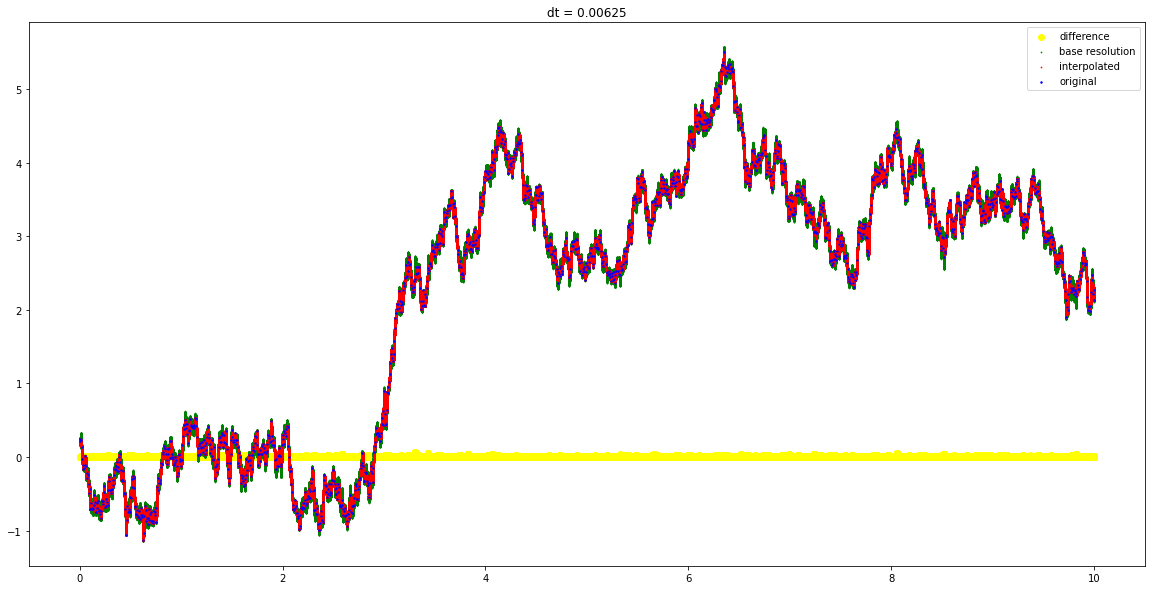

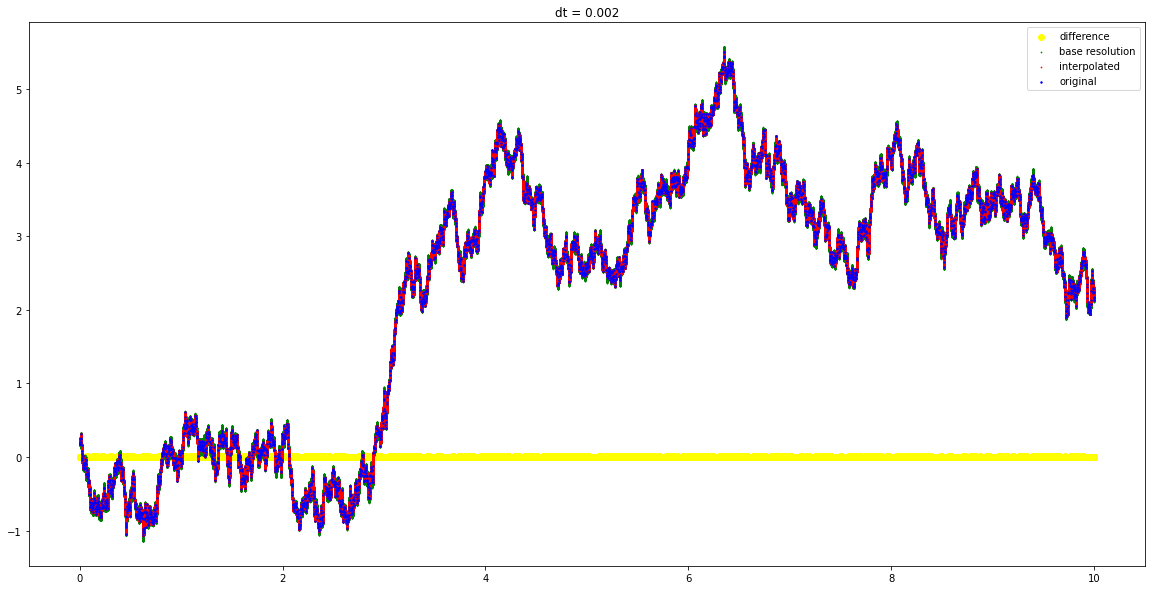

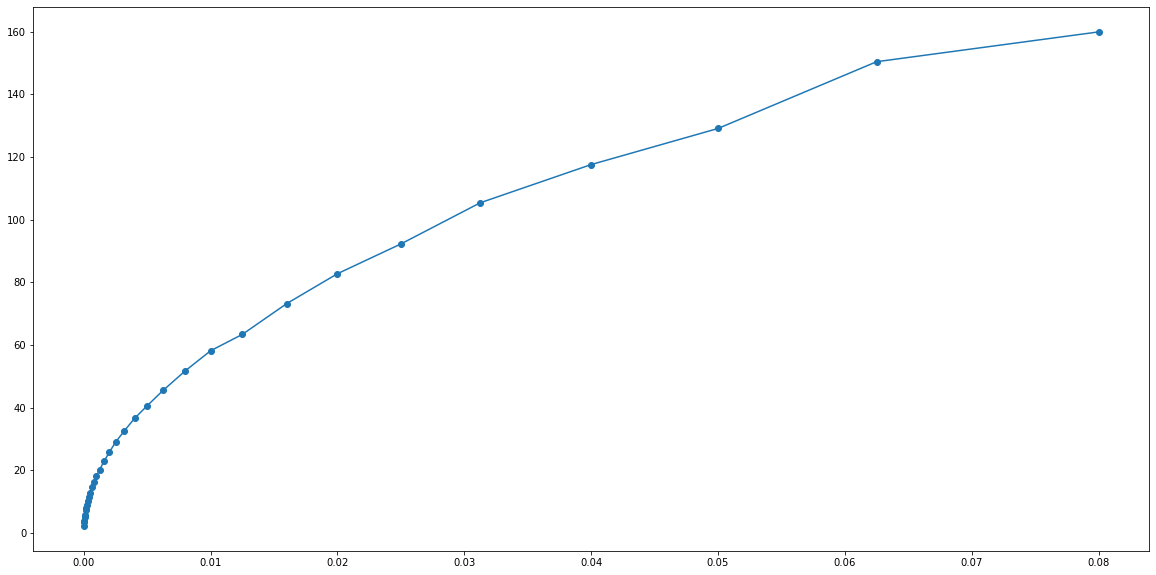

In [54]:
zeroParticle = particles[-1]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
deltas = []

coarserParticles = particles[:-1] #all particles except the reference one
coarserResolutions = resolutions[:-1] #all resolutions except the reference one

numberOfPlots = 3+1 #excludes last plot with perfect interpolation (this will produce 3 plots)
particleIndecesToPlot = len(coarserParticles)//np.arange(4)

print(particleIndecesToPlot)
for index, particle in tqdm(enumerate(coarserParticles)):
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    delta = np.linalg.norm(zeroZs - zs_interpolated, ord = 2)
    deltas.append(delta)
    if index in particleIndecesToPlot:
        plt.figure(figsize=(20,10))
        plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
        plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
        plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
        plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
        plt.legend(loc = "upper right")
        plt.title(f"dt = {particle.dt}")

plt.figure(figsize=(20,10))
plt.plot(coarserResolutions, deltas, marker = "o")

  0%|          | 0/33 [00:00<?, ?it/s]

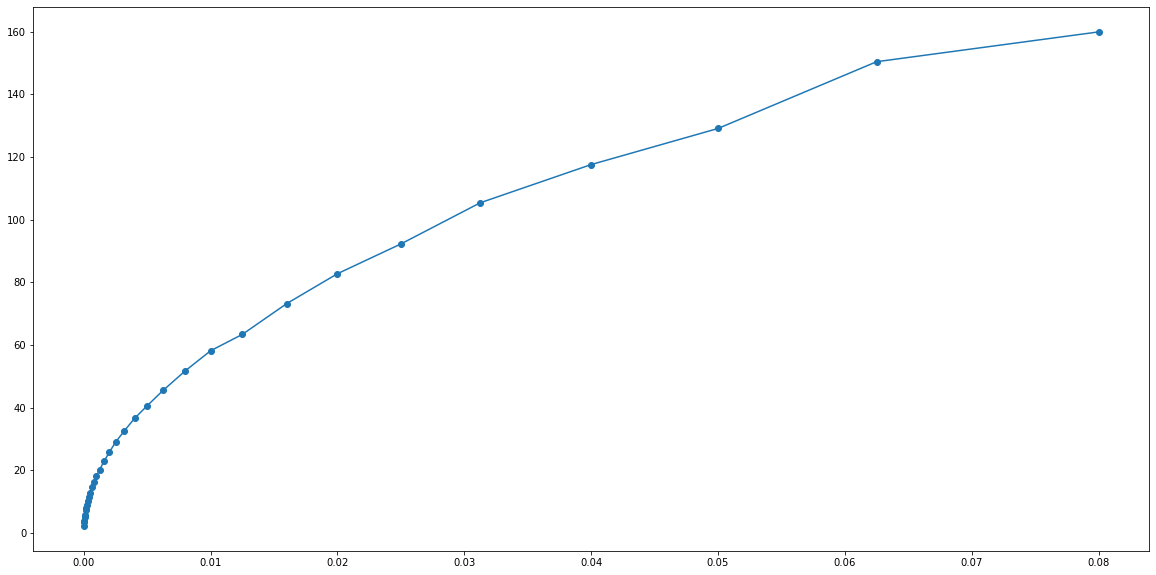

In [55]:
zeroParticle = particles[-1]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
deltas = []

coarserParticles = particles[:-1] #all particles except the reference one
coarserResolutions = resolutions[:-1] #all resolutions except the reference one

for particle in tqdm(coarserParticles):
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    delta = np.linalg.norm(zeroZs - zs_interpolated, ord = 2)
    deltas.append(delta)

plt.figure(figsize=(20,10))
plt.plot(coarserResolutions, deltas, marker = "o")


  0%|          | 0/19 [00:00<?, ?it/s]

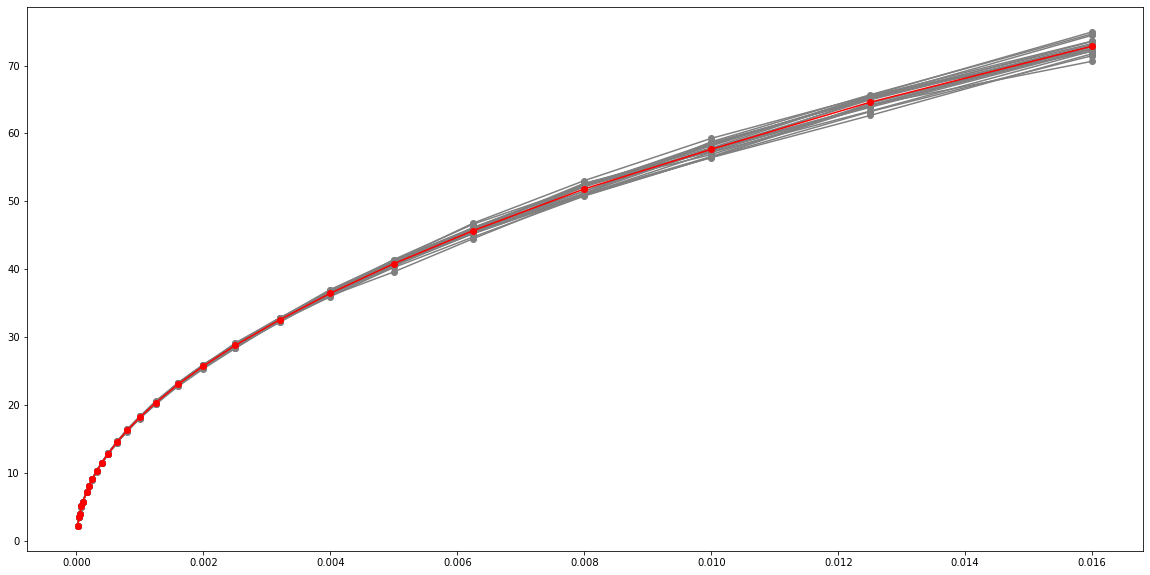

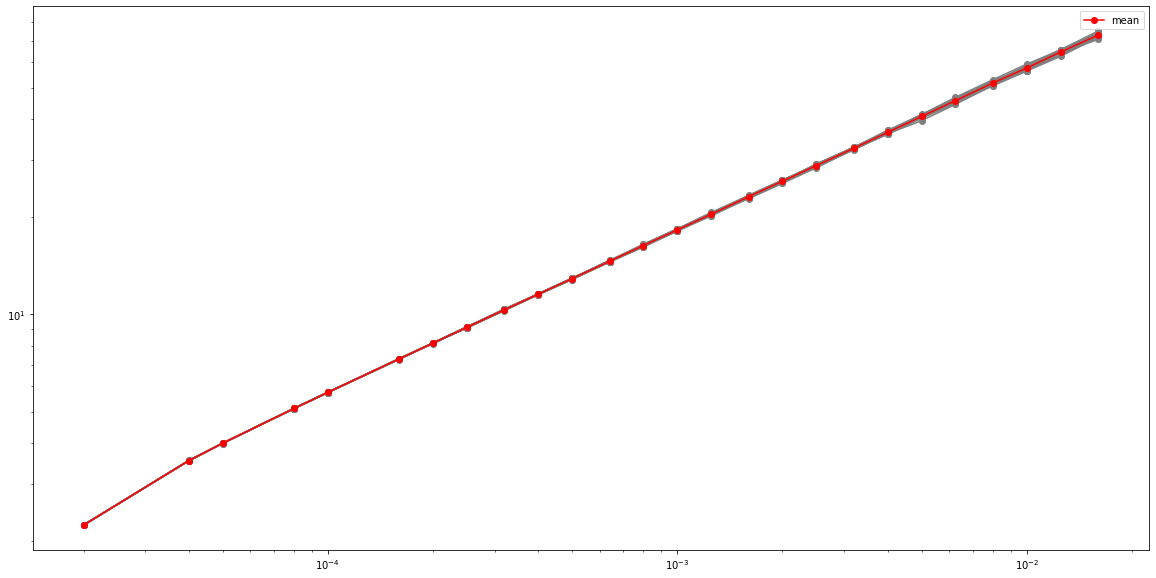

In [56]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

realizationDeltas = []

for realization in tqdm(np.arange(1,20)):
    iterlist = np.arange(1,2000)
    iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
    maxnth = iterlist[0]

    particles = []
    resolutions = []
    baseSteps = 1000000
    for i in iterlist:
        if baseSteps%i == 0:
            #print("readtime:")
            ts, ws, dws, dt = getWeinerSubset(i,baseSteps,10,realization)
            particle = Particle(0.25)
            #print("simulate time:")
            zs = particle.simulate(ts, dws, dt)
            particles.append(particle)

            #plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))
            resolutions.append(dt)

    #plt.legend(bbox_to_anchor=(1, 1))
    #plt.show()

    zeroParticle = particles[-1]  #Highest resolution track
    zeroZs = np.array(zeroParticle.zs)
    zeroTs = np.array(zeroParticle.ts)
    deltas = []

    coarserParticles = particles[:-1] #all particles except the reference one
    coarserResolutions = resolutions[:-1] #all resolutions except the reference one

    for particle in coarserParticles:
        zs = np.array(particle.zs)
        ts = np.array(particle.ts)
        zs_interpolated = np.interp(zeroTs, ts, zs)
        delta = np.linalg.norm(zeroZs - zs_interpolated, ord = 2)
        deltas.append(delta)
        #plt.figure(figsize=(20,10))
        #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
        #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
        #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
        #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
        #plt.legend()
        #plt.title(f"dt = {particle.dt}")
    realizationDeltas.append(np.array(deltas))
    
    ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
    ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")
    

realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)
ax1.plot(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
plt.legend()

## Exponential fit

https://stackoverflow.com/questions/32536226/log-log-plot-linear-regression

In [57]:
def power(x,a,b):
    return a * np.power(x, b)

In [58]:
popt, pcov = curve_fit(power, coarserResolutions, realizationDeltasMean)

C:\Users\serva\AppData\Local\Temp/ipykernel_24744/4072316904.py:2: RuntimeWarning: overflow encountered in power
  return a * np.power(x, b)


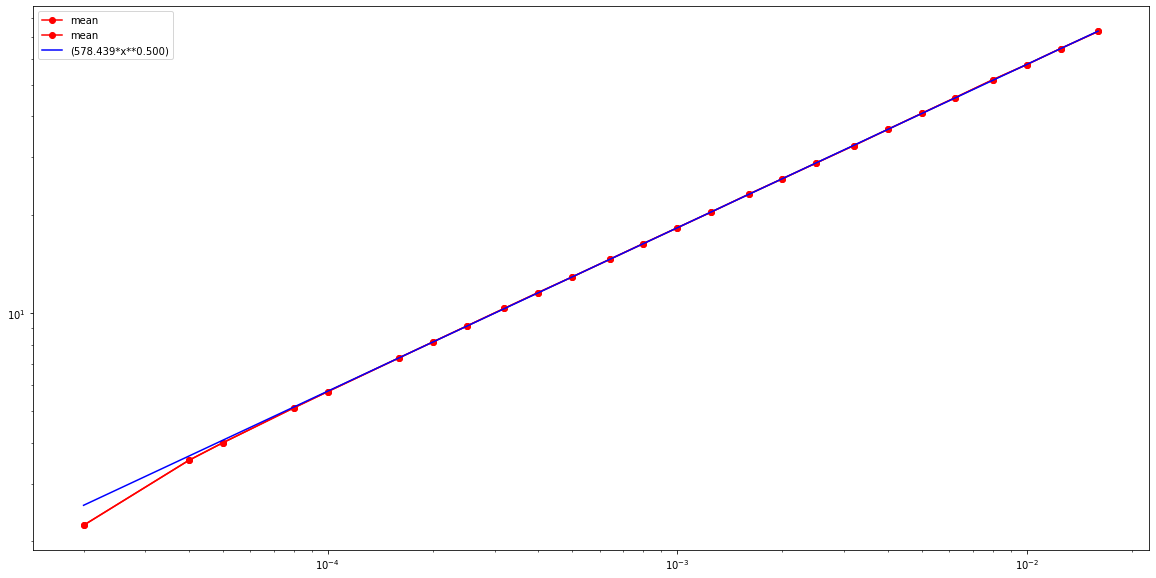

In [59]:
plt.figure(figsize=(20,10))

plt.plot(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
plt.loglog(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
plt.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="({0:.3f}*x**{1:.3f})".format(*popt))
plt.legend()

# Final code

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\serva\AppData\Local\Temp/ipykernel_24744/4261103377.py:60: RuntimeWarning: overflow encountered in power
  return a * np.power(x, b)


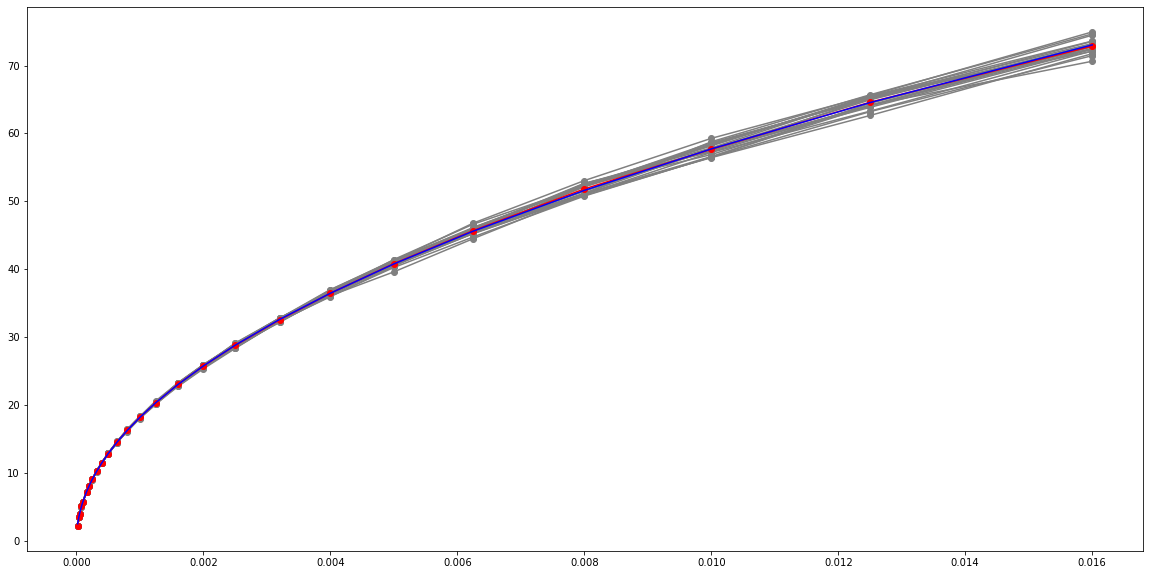

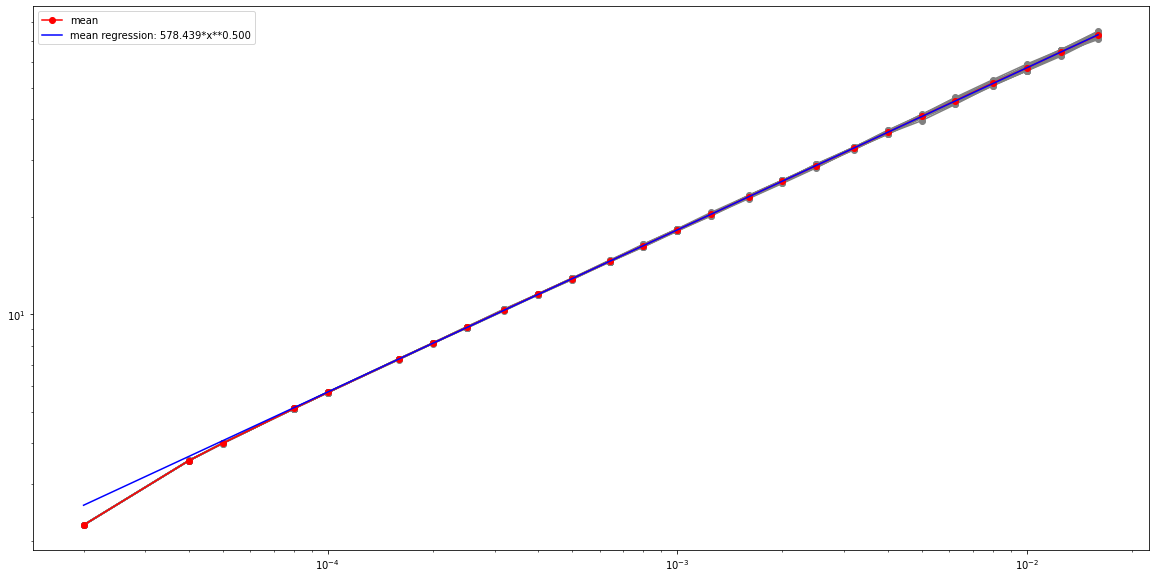

In [60]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

realizationDeltas = []

for realization in tqdm(np.arange(1,20)):
    iterlist = np.arange(1,2000)
    iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
    maxnth = iterlist[0]

    particles = []
    resolutions = []
    baseSteps = 1000000
    for i in iterlist:
        if baseSteps%i == 0:
            #print("readtime:")
            ts, ws, dws, dt = getWeinerSubset(i,baseSteps,10,realization)
            particle = Particle(0.25)
            #print("simulate time:")
            zs = particle.simulate(ts, dws, dt)
            particles.append(particle)

            #plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))
            resolutions.append(dt)

    #plt.legend(bbox_to_anchor=(1, 1))
    #plt.show()

    zeroParticle = particles[-1]  #Highest resolution track
    zeroZs = np.array(zeroParticle.zs)
    zeroTs = np.array(zeroParticle.ts)
    deltas = []

    coarserParticles = particles[:-1] #all particles except the reference one
    coarserResolutions = resolutions[:-1] #all resolutions except the reference one

    for particle in coarserParticles:
        zs = np.array(particle.zs)
        ts = np.array(particle.ts)
        zs_interpolated = np.interp(zeroTs, ts, zs)
        delta = np.linalg.norm(zeroZs - zs_interpolated, ord = 2)
        deltas.append(delta)
        #plt.figure(figsize=(20,10))
        #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
        #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
        #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
        #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
        #plt.legend()
        #plt.title(f"dt = {particle.dt}")
    realizationDeltas.append(np.array(deltas))
    
    ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
    ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")

realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)

def power(x,a,b):
    return a * np.power(x, b)
popt, pcov = curve_fit(power, coarserResolutions, realizationDeltasMean)

ax1.plot(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax1.plot(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
ax2.loglog(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
plt.legend()